<!-- #region -->

# 最优化与深度学习

在本节中，我们将讨论最优化与深度学习之间的关系，以及在深度学习中使用最优化所面临的挑战。
对于深度学习问题，通常先定义一个 *损失函数*（loss function）。一旦有了损失函数，我们就可以使用一个最优化算法来尝试最小化损失。在最优化中，损失函数通常被称为最优化问题的 *目标函数*（objective function）。根据传统和惯例，大多数最优化算法都与 *最小化*（minimization）有关。如果我们需要最大化一个目标函数，有一个简单的解决方案：只要翻转目标函数前面的符号即可。

## 优化目标

虽然最优化为深度学习提供了一种最小化损失函数的方法，但从本质上讲，最优化和深度学习的目标是完全不同的。
前者主要关注最小化目标函数，而后者则关注在给定有限数据量的情况下找到合适的模型。
在 :numref:`sec_model_selection` 中，我们详细讨论了这两个目标之间的差异。
例如，通常情况下训练误差和泛化误差是不同的：因为最优化算法的目标函数一般是基于训练数据集的损失函数，所以最优化的目标是减少训练误差。
然而，深度学习（或者广义上说，统计推断）的目标是减少泛化误差。
为了实现后者的目标，除了使用最优化算法来减少训练误差外，还需要注意过拟合问题。


In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
from mpl_toolkits import mplot3d
from d2l import tensorflow as d2l


为了说明上述的不同目标，让我们考虑经验风险和风险。
如 :numref:`subsec_empirical-risk-and-risk` 所描述的，经验风险是训练数据集上的平均损失，而风险是全体数据的期望损失。
接下来我们定义两个函数，风险函数 $f$ 和经验风险函数 $g$。
假设我们拥有的训练数据的数量是有限的，因此函数 $g$ 不如 $f$ 平滑。


In [2]:
def f(x):
    return x * tf.cos(np.pi * x)

def g(x):
    return f(x) + 0.2 * tf.cos(5 * np.pi * x)

下图说明了，在训练数据集上，经验风险的最小值可能与风险（泛化误差）的最小值不在相同的位置。


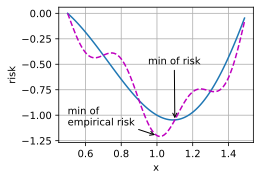

In [3]:
def annotate(text, xy, xytext):  #@save
    d2l.plt.gca().annotate(text, xy=xy, xytext=xytext,
                           arrowprops=dict(arrowstyle='->'))

x = tf.range(0.5, 1.5, 0.01)
d2l.set_figsize((4.5, 2.5))
d2l.plot(x, [f(x), g(x)], 'x', 'risk')
annotate('min of\nempirical risk', (1.0, -1.2), (0.5, -1.1))
annotate('min of risk', (1.1, -1.05), (0.95, -0.5))

## 深度学习中的最优化挑战

在本章中，我们将特别关注最优化算法在最小化目标函数方面的性能，而不是模型的泛化误差。
在 :numref:`sec_linear_regression` 中，我们对比了最优化问题的解析解和数值解。
在深度学习中，大多数目标函数是复杂的、没有解析解的。
因此，我们必须使用本章所描述的数值最优化算法来代替解析算法。

深度学习的最优化面临许多挑战，其中最令人烦恼的是局部极小值、鞍点和消失梯度。
下面我们将具体了解这些挑战。

### 局部最小值

对于目标函数 $f(x)$，如果 $x$ 处的 $f(x)$ 值小于 $x$ 附近任何其他点的 $f(x)$ 值，则 $f(x)$ 可以是 *局部最小值*（local minimum）。
如果在 $x$ 处 $f(x)$ 的值是目标函数在整个域上的最小值，则 $f(x)$ 是 *全局最小值*（global minimum）。

例如，给定函数

$$f(x) = x \cdot \text{cos}(\pi x) \text{ for } -1.0 \leq x \leq 2.0,$$

我们可以近似这个函数的局部最小值和全局最小值。


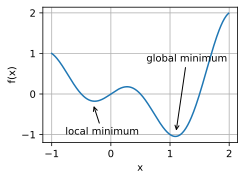

In [4]:
x = tf.range(-1.0, 2.0, 0.01)
d2l.plot(x, [f(x),], 'x', 'f(x)')
annotate('local minimum', (-0.3, -0.25), (-0.77, -1.0))
annotate('global minimum', (1.1, -0.95), (0.6, 0.8))

通常深度学习模型的目标函数具有许多局部最优解。
当最优化问题的数值解接近局部最优解时，会导致求解目标函数的梯度趋于或者变为零，此时通过最终迭代得到的数值解只可能使目标函数 *局部最小化*（locally），而不是 *全局最小化*（globally）。
只有一定程度的噪声才能使参数脱离局部极小值。
事实上，小批量随机梯度下降的一个有利性质就是基于小批量上的梯度的自然变化能够强行将参数从局部极小值中移出。

### 鞍点

除了局部极小值，鞍点是梯度消失的另一个原因。*鞍点*（saddle point）也是函数的所有梯度都消失的位置，但这个位置既不是全局最小值也不是局部最小值。
考虑函数 $f(x) = x^3$，它的一阶导数和二阶导数在 $x=0$ 处消失。
即使 $x$ 不是最小值，优化也可能在这个点上停止。


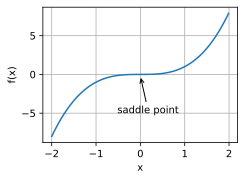

In [5]:
x = tf.range(-2.0, 2.0, 0.01)
d2l.plot(x, [x**3], 'x', 'f(x)')
annotate('saddle point', (0, -0.2), (-0.52, -5.0))

如下例所示，更高维度中的鞍点将更加隐蔽。考虑函数 $f(x, y) = x^2 - y^2$，
它的鞍点在 $(0, 0)$，这是 $y$ 的最大值，$x$ 的最小值。
而且，它看起来像一个马鞍，这也就是这个数学性质命名的原因。


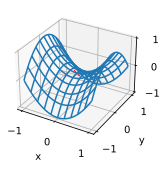

In [6]:
x, y = tf.meshgrid(tf.linspace(-1.0, 1.0, 101), tf.linspace(-1.0, 1.0, 101))
z = x**2 - y**2

ax = d2l.plt.figure().add_subplot(111, projection='3d')
ax.plot_wireframe(x, y, z, **{'rstride': 10, 'cstride': 10})
ax.plot([0], [0], [0], 'rx')
ticks = [-1, 0, 1]
d2l.plt.xticks(ticks)
d2l.plt.yticks(ticks)
ax.set_zticks(ticks)
d2l.plt.xlabel('x')
d2l.plt.ylabel('y');

我们假设一个函数的输入是一个 $k$ 维向量，其输出是一个标量，因此它的 Hessian 矩阵将有 $k$ 个特征值（参见 :numref:`sec_geometry-linear-algebraic-ops`）。
函数的解可以是局部最小值、局部最大值或者鞍点，解所在位置的函数梯度为零：

* 当函数的 Hessian 矩阵在零梯度位置的特征值都为正时，我们得到了函数的局部极小值。
* 当函数的 Hessian 矩阵在零梯度位置的特征值都为负时，我们得到了函数的局部极大值。
* 当函数的 Hessian 矩阵在零梯度位置的特征值有负有正时，我们得到了函数的鞍点。

对于高维问题，至少某些特征值为负的可能性是相当高的，因此得到函数的鞍点比局部极小值的可能性更高。
在下一节介绍凸性时，我们将讨论这种形势下的一些例外情况。简而言之，*凸函数* 是那些 Hessian 函数的特征值从不为负的函数。
遗憾的是，大多数的深度学习问题都不属于这类函数。然而，它仍然是研究优化算法一个伟大的工具。

### 梯度消失

回忆一下我们常用的激活函数及它们的导数 :numref:`subsec_activation-functions`，*梯度消失*（vanishing gradients）可能是会遇到的最隐蔽的问题。
举个例子，假设我们想从 $x = 4$ 开始最小化函数 $f(x) = \tanh(x)$。
如我们所见，$f$ 的梯度接近于零，更具体地说就是$f'(x) = 1 - \tanh^2(x)$ 和 $f'(4) = 0.0013$。
结果，在我们取得进展之前，优化将被困在那个位置很长一段时间。
这就是为什么深度学习模型的训练在引入 ReLU 激活函数之前相当棘手的原因之一。


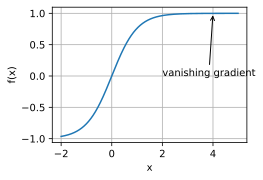

In [7]:
x = tf.range(-2.0, 5.0, 0.01)
d2l.plot(x, [tf.tanh(x)], 'x', 'f(x)')
annotate('vanishing gradient', (4, 1), (2, 0.0))

正如我们所看到的，深度学习的优化充满了挑战。
幸运的是，存在一个强大的、表现良好的、即使对于初学者也易于使用的算法范围。
此外，没有必要找到最佳解决方案，因为局部最优解甚至近似解仍然是非常有用的。


## 小结

* 最小化训练误差并不能保证我们找到一组最佳的参数来最小化泛化误差。
* 最优化问题可能存在许多局部极小值。
* 因为通常情况下机器学习问题都不是凸性的，所以优化问题可能有许多鞍点。
* 梯度消失会导致优化停滞。通常问题的重新参数化会有所帮助。良好的参数初始化也可能是有益的。

## 练习

1. 考虑一个简单的多层感知机，其有一个 $d$ 维的隐藏层和一个输出。证明对于任何局部最小值至少有 $d!$ 个行为相同的等价解。
1. 假设我们有一个对称随机矩阵 $\mathbf{M}$，其中元素 $M_{ij} = M_{ji}$ ，并且每个元素都是基于某个概率分布 $p_{ij}$ 提取出来的。此外，假设 $p_{ij}(x) = p_{ij}(-x)$，即分布是对称的（详见 :cite:`Wigner.1958` ）。
    * 证明了特征值上的分布也是对称的。即对于任何特征向量 $\mathbf{v}$，相关特征值 $\lambda$ 的概率满足 $P(\lambda > 0) = P(\lambda < 0)$ 。
    * 为什么上面的证明 *没有* 隐含 $P(\lambda > 0) = 0.5$？
1. 在深度学习优化过程中，你还能想到哪些挑战？
1. 假设你想在一个（真实的）马鞍上平衡一个（真实的）球。
    * 为什么这么难？
    * 你能利用这种效果优化算法吗？


[Discussions](https://discuss.d2l.ai/t/489)


<!-- #endregion -->
